# Introduction
- 参考ノートブック`brute-force-feature-engineering.ipynb`で400以上の特徴量を作っていた。今では、この400のうち、上位400の特徴量を使っていたが、すべて使った場合、精度があがるのかを確認してみる。

# Import everything I need :)

In [1]:
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
# from tq

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 26
isSmallSet = False
length = 2000

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [9]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

**basic**

In [11]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

distances

In [12]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 595.28 Mb (11.8% reduction)
Mem. usage decreased to 301.07 Mb (12.5% reduction)


`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [13]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

create_features_full
- these features calculate statistics per molecules;
- several features are calculated for molecules in general;
- most features are calculated for molecules and one of categorical variables;
- I wanted to use all combinations of features and more aggregates, but kernel RAM isn't enough :(
- also I wanted to calculated differences between aggregated and original values 

In [14]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

#     for cat_col in tqdm_notebook(cat_cols):
    for cat_col in cat_cols:
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]

    df = reduce_mem_usage(df)
    return df

In [15]:
train = create_features_full(train)
test  = create_features_full(test)

Mem. usage decreased to 15761.48 Mb (1.4% reduction)
Mem. usage decreased to 8458.73 Mb (1.4% reduction)


---
LabelEncode
- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [16]:
for f in ['atom_1', 'type_0', 'type']:
    if f in train.columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

---
**show features**

In [17]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,molecule_dist_std,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_count,molecule_atom_index_1_count,molecule_type_count,molecule_atom_1_count,molecule_type_0_count,molecule_atom_index_0_x_1_mean,molecule_atom_index_0_x_1_mean_diff,molecule_atom_index_0_x_1_mean_div,molecule_atom_index_0_x_1_max,molecule_atom_index_0_x_1_max_diff,molecule_atom_index_0_x_1_max_div,molecule_atom_index_0_x_1_std,molecule_atom_index_0_x_1_std_diff,molecule_atom_index_0_x_1_std_div,molecule_atom_index_0_x_1_min,molecule_atom_index_0_x_1_min_diff,molecule_atom_index_0_x_1_min_div,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_max_div,molecule_atom_index_0_y_1_std,...,molecule_type_0_z_1_min_diff,molecule_type_0_z_1_min_div,molecule_type_0_dist_mean,molecule_type_0_dist_mean_diff,molecule_type_0_dist_mean_div,molecule_type_0_dist_max,molecule_type_0_dist_max_diff,molecule_type_0_dist_max_div,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_0_dist_std_div,molecule_type_0_dist_min,molecule_type_0_dist_min_diff,molecule_type_0_dist_min_div,molecule_type_0_dist_x_mean,molecule_type_0_dist_x_mean_diff,molecule_type_0_dist_x_mean_div,molecule_type_0_dist_x_max,molecule_type_0_dist_x_max_diff,molecule_type_0_dist_x_max_div,molecule_type_0_dist_x_std,molecule_type_0_dist_x_std_diff,molecule_type_0_dist_x_std_div,molecule_type_0_dist_x_min,molecule_type_0_dist_x_min_diff,molecule_type_0_dist_x_min_div,molecule_type_0_dist_y_mean,molecule_type_0_dist_y_mean_diff,molecule_type_0_dist_y_mean_div,molecule_type_0_dist_y_max,molecule_type_0_dist_y_max_diff,molecule_type_0_dist_y_max_div,molecule_type_0_dist_y_std,molecule_type_0_dist_y_std_diff,molecule_type_0_dist_y_std_div,molecule_type_0_dist_y_min,molecule_type_0_dist_y_min_diff,molecule_type_0_dist_y_min_div,molecule_type_0_dist_z_mean,molecule_type_0_dist_z_mean_diff,molecule_type_0_dist_z_mean_div,molecule_type_0_dist_z_max,molecule_type_0_dist_z_max_diff,molecule_type_0_dist_z_max_div,molecule_type_0_dist_z_std,molecule_type_0_dist_z_std_diff,molecule_type_0_dist_z_std_div,molecule_type_0_dist_z_min,molecule_type_0_dist_z_min_diff,molecule_type_0_dist_z_min_div
0,0,dsgdb9nsd_000001,1,0,0,84.8076,H,0.00215,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,1.091953,0.000220,1.192105,0.000036,0,10,1.506668,1.091946,1.783158,0.356932,4,4,10,10,10,10,10,-0.016399,-0.003701,1.291449,1.011731,1.024429,-79.675541,0.727907,0.740605,-57.323938,-0.540815,-0.528117,42.590115,1.358754,0.272949,1.251380,1.463751,0.377947,1.34808,0.182278,...,0.00000,1.000000,1.091950,-0.000003,0.999997,1.091953,0.000000,1.000000,0.000003,-1.091950,0.000003,1.091946,-0.000007,0.999994,0.397455,0.397235,1802.686652,1.049455,1.049234,4759.874563,0.452956,0.452735,2054.412944,0.000220,0.000000,1.000000,0.397447,-0.794658,0.333399,1.192105,0.0,1.0,0.529829,-0.662275,0.444449,0.123994,-1.068110,0.104013,0.397452,0.397416,10949.356227,0.807116,0.807080,2.223513e+04,0.458992,0.458956,12644.708608,0.000036,0.0,1.0
1,1,dsgdb9nsd_000001,1,2,3,-11.2570,H,0.00215,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1.783120,1.019253,2.160261,0.000003,1,10,1.506668,1.091946,1.783158,0.356932,4,1,10,10,10,10,10,-0.016399,-1.028130,-0.016209,1.011731,0.000000,1.000000,0.727907,-0.283824,0.719467,-0.540815,-1.552546,-0.534544,1.358754,-0.104998,0.928268,1.463751,0.000000,1.00000,0.182278,...,-0.87692,-3169.644216,1.783146,0.000027,1.000015,1.783158,0.000038,1.000021,0.000014,-1.783106,0.000008,1.783120,0.000000,1.000000,1.059881,0.040629,1.039861,2.410399,1.391146,2.364869,1.079994,0.060741,1.059594,0.000289,-1.018964,0.000284,1.059857,-1.100403,0.490616,2.160261,0.0,1.

In [18]:
print(len(test.columns))
print(test.columns)

450
Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'atom_0',
       'x_0', 'y_0', 'z_0', 'atom_1',
       ...
       'molecule_type_0_dist_z_mean_div', 'molecule_type_0_dist_z_max',
       'molecule_type_0_dist_z_max_diff', 'molecule_type_0_dist_z_max_div',
       'molecule_type_0_dist_z_std', 'molecule_type_0_dist_z_std_diff',
       'molecule_type_0_dist_z_std_div', 'molecule_type_0_dist_z_min',
       'molecule_type_0_dist_z_min_diff', 'molecule_type_0_dist_z_min_div'],
      dtype='object', length=450)


# create train, test data

In [19]:
y = train['scalar_coupling_constant']
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)

X = train.copy()
X_test = test.copy()

In [20]:
del train, test

In [21]:
gc.collect()

35

# Training model

**params**

In [22]:
# Configuration
TARGET = 'scalar_coupling_constant'
# CAT_FEATS = ['type']
N_ESTIMATORS = 1500
VERBOSE = 300
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error
N_JOBS = multiprocessing.cpu_count() -1

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


In [23]:
n_folds = 4
folds = KFold(n_splits=n_folds, shuffle=True)

In [24]:
# init

def train_lgb(X, X_test, y, lgb_params, folds,
              verbose, early_stopping_rounds, n_estimators):

    result_dict = {}
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    models = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print('------------------')
        print(f'- fold{fold_n + 1}' )
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        

        # Train the model
        model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=N_JOBS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # predict
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   
        y_test_pred = model.predict(X_test)

        oof[valid_idx] = y_valid_pred.reshape(-1,)  # oof: out of folds
        scores.append(mean_absolute_error(y_valid, y_valid_pred))

        prediction += y_test_pred

        # feature_importance
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X.columns
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    # result
    prediction /= folds.n_splits
    feature_importance["importance"] /= folds.n_splits
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = feature_importance


    print('------------------')
    print('====== finish ======')
    print('score list:', scores)
    X['scalar_coupling_constant'] = y
    cv_score = kaggle_metric(X, oof)
#     X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
    print('CV mean score(group log mae): {0:.4f}'.format(cv_score))

    
    return result_dict, cv_score

In [25]:
# train
result_dict, cv_score = train_lgb(X=X, X_test=X_test, y=y, lgb_params=lgb_params, folds=folds,
                        verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                        n_estimators=N_ESTIMATORS)

X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)

------------------
- fold1
Fold 1 started at Tue Jul 16 05:36:14 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 1.19821	valid_1's l1: 1.2426
[600]	training's l1: 1.06712	valid_1's l1: 1.14397
[900]	training's l1: 0.984477	valid_1's l1: 1.08938
[1200]	training's l1: 0.921499	valid_1's l1: 1.05125
[1500]	training's l1: 0.873955	valid_1's l1: 1.02688
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.873955	valid_1's l1: 1.02688
------------------
- fold2
Fold 2 started at Tue Jul 16 06:22:23 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 1.20104	valid_1's l1: 1.24436
[600]	training's l1: 1.06862	valid_1's l1: 1.14485
[900]	training's l1: 0.985949	valid_1's l1: 1.09089
[1200]	training's l1: 0.925477	valid_1's l1: 1.05593
[1500]	training's l1: 0.876166	valid_1's l1: 1.03016
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.876166	valid_1's l1: 1.03016
-------------

## plot feature importance

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



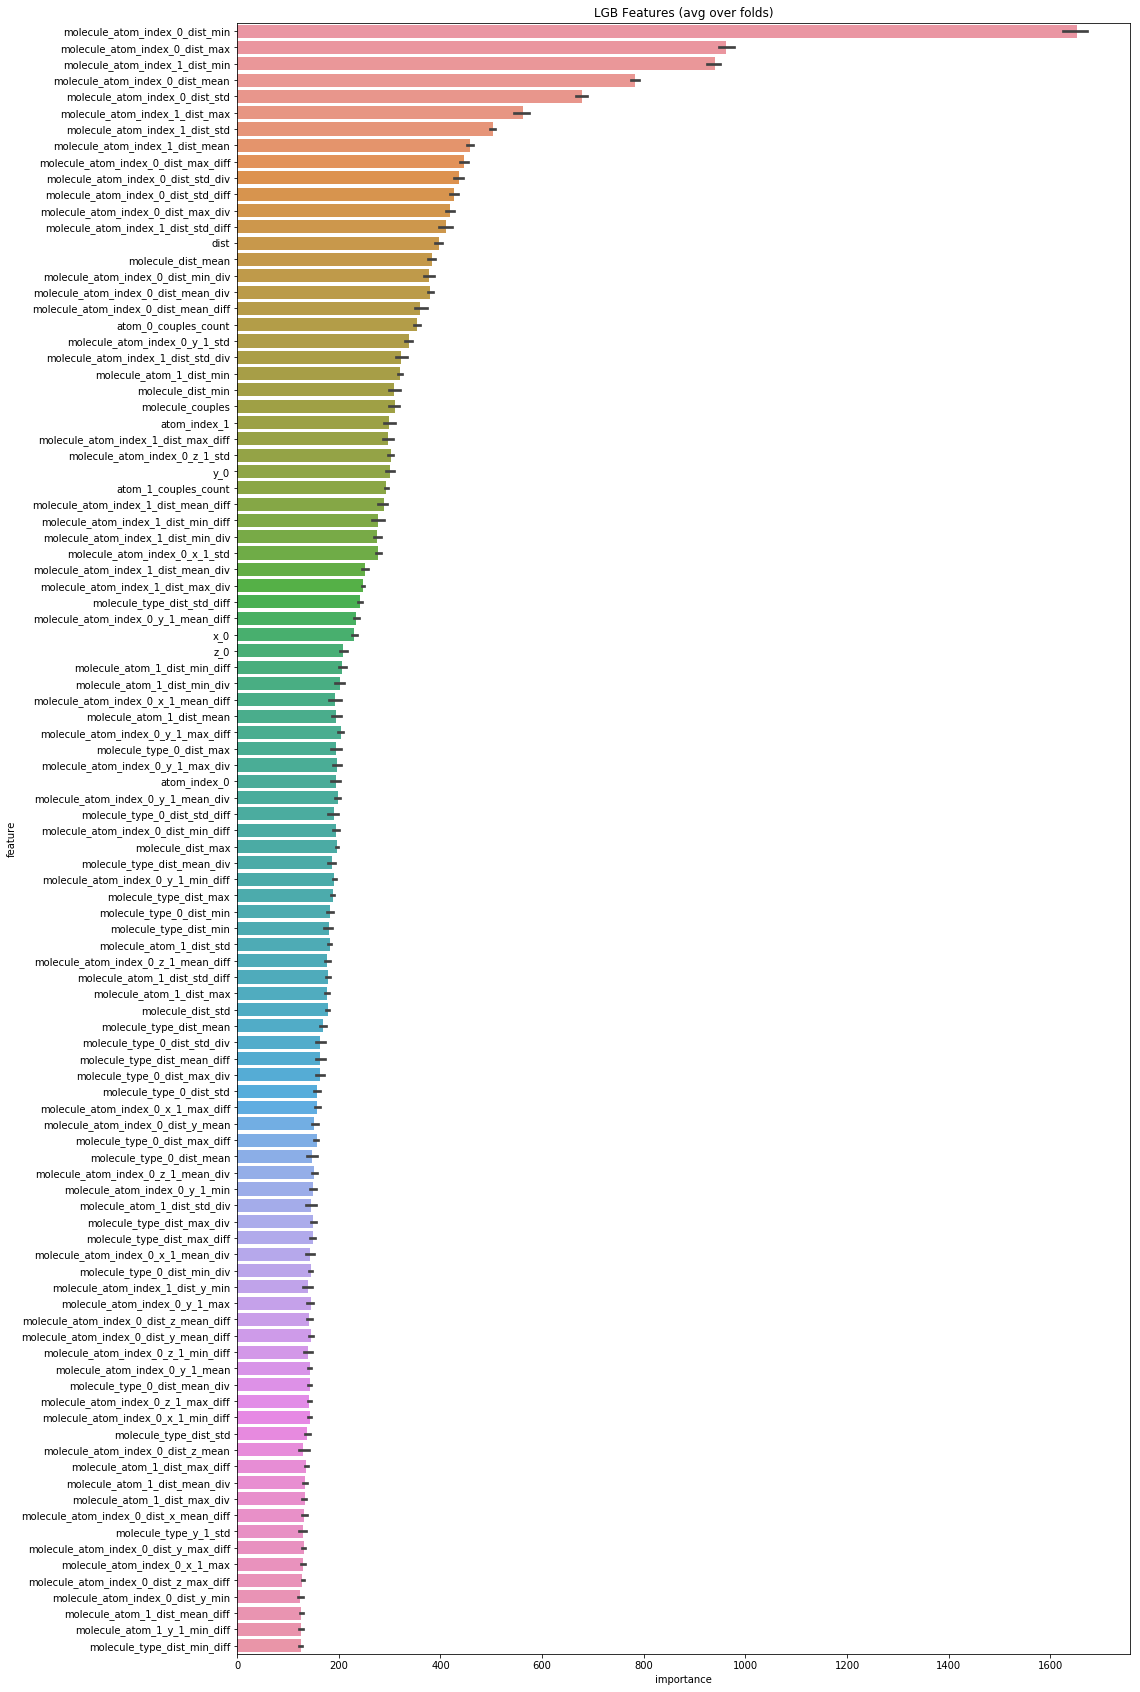

In [49]:
# top n features
n_feat = 100


feature_importance = result_dict['feature_importance']
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 30));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [45]:
cols

Index(['molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_1_dist_min', 'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_std', 'molecule_atom_index_1_dist_max',
       'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_mean',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_std_div',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_max_div',
       'molecule_atom_index_1_dist_std_diff', 'dist', 'molecule_dist_mean',
       'molecule_atom_index_0_dist_mean_div',
       'molecule_atom_index_0_dist_min_div',
       'molecule_atom_index_0_dist_mean_diff', 'atom_0_couples_count',
       'molecule_atom_index_0_y_1_std', 'molecule_atom_index_1_dist_std_div',
       'molecule_atom_1_dist_min', 'molecule_couples', 'molecule_dist_min',
       'molecule_atom_index_0_z_1_std', 'y_0', 'atom_index_1',
       'molecule_atom_index_1_dist_max_diff', 'atom_1_couples

# Save

**submission**

In [27]:
path_submittion = '../output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
# path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_submittion}')

save pash: ../output/nb26_submission_lgb_-0.09651824202075901.csv


In [28]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[:100]
submittion['scalar_coupling_constant'] = result_dict['prediction']
submittion.to_csv(path_submittion, index=False)

---
**result**

In [29]:
path_oof = '../output/' + 'nb{}_oof_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_oof}')

save pash: ../output/nb26_oof_lgb_-0.09651824202075901.csv


In [30]:
oof = pd.DataFrame(result_dict['oof'])
oof.to_csv(path_oof, index=False)

# analysis

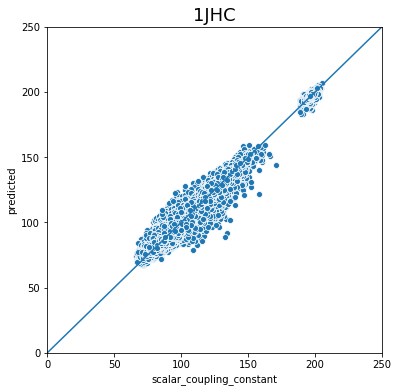

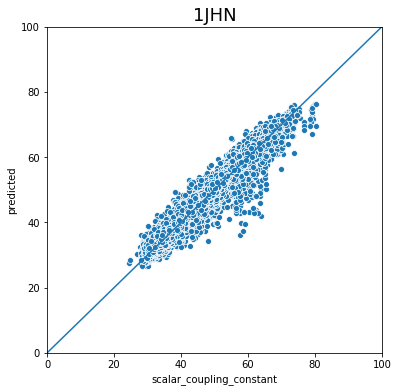

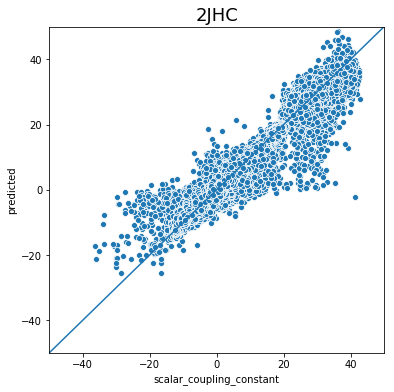

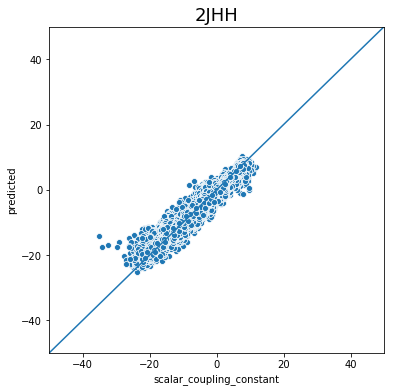

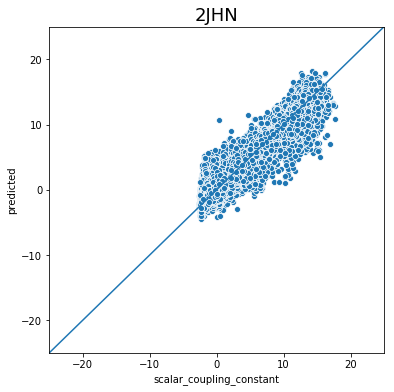

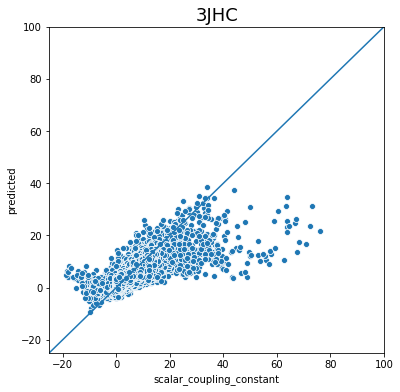

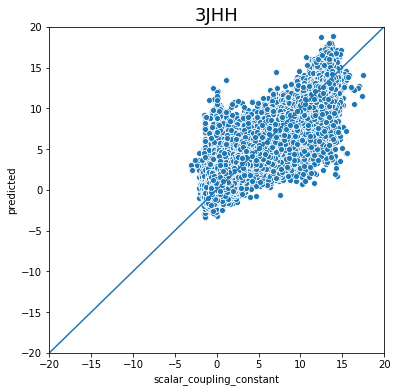

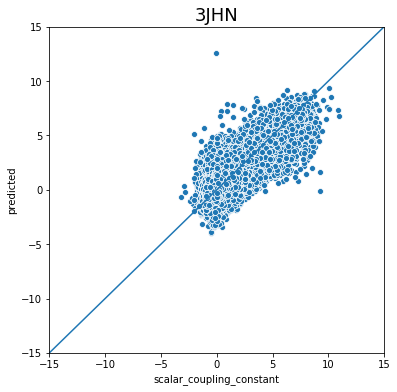

In [31]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)